In [ ]:
!pip install torch numpy matplotlib tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

Epoch 100/100: 100%|██████████| 6/6 [00:01<00:00,  5.87it/s, loss=0.0515, lr=3.74e-9]


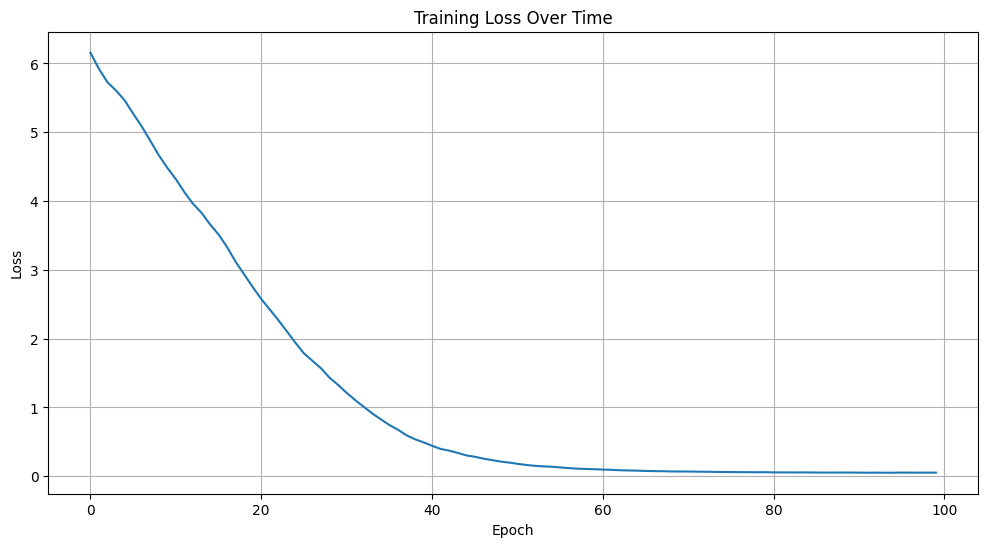


--- PROFESSIONAL POST ---
proud to announce that our team successfully launched the new customer portal ahead of schedule! this project wouldn ' t have been possible without the dedication and collaboration of our amazing development team. #teamwork #projectsuccess #softwaredevelopment
--------------------------------------------------

--- MOTIVATIONAL POST ---
failed my first technical interview five years ago. today i ' m leading a team of 15 engineers. sometimes rejection is just redirection toward something better. keep pushing forward. #resilience #careergrowth #nevergiveup
--------------------------------------------------

--- INDUSTRY_INSIGHTS POST ---
remote work has fundamentally changed how we think about talent acquisition. geography is no longer a barrier to incorporate ai tools will have a significant competitive advantage. the question isn ' t whether to adopt ai, but how quickly you can do it effectively. #ai #innovation #futureofwork
---------------------------------

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import json
import re
import pickle
from typing import List, Dict, Optional, Tuple
import math
import random
from pathlib import Path
import logging
from dataclasses import dataclass
from tqdm import tqdm
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

@dataclass
class ModelConfig:
    vocab_size: int = 10000
    max_seq_length: int = 512
    d_model: int = 512
    n_heads: int = 8
    n_layers: int = 6
    d_ff: int = 2048
    dropout: float = 0.1
    learning_rate: float = 1e-4
    batch_size: int = 16
    num_epochs: int = 100
    warmup_steps: int = 1000
    max_grad_norm: float = 1.0
    num_themes: int = 20

class ImprovedTokenizer:
    def __init__(self):
        self.vocab = {}
        self.reverse_vocab = {}
        self.special_tokens = {
            '<PAD>': 0,
            '<UNK>': 1,
            '<BOS>': 2,
            '<EOS>': 3,
            '<MASK>': 4
        }
        self.vocab.update(self.special_tokens)
        self.reverse_vocab.update({v: k for k, v in self.special_tokens.items()})

    def build_vocab(self, texts: List[str], min_freq: int = 1):
        word_counts = {}

        for text in texts:
            tokens = self._tokenize(text)
            for token in tokens:
                word_counts[token] = word_counts.get(token, 0) + 1

        vocab_size = len(self.special_tokens)
        for word, count in sorted(word_counts.items(), key=lambda x: x[1], reverse=True):
            if count >= min_freq and vocab_size < 15000:
                self.vocab[word] = vocab_size
                self.reverse_vocab[vocab_size] = word
                vocab_size += 1

        logger.info(f"Built vocabulary with {len(self.vocab)} tokens")

    def _tokenize(self, text: str) -> List[str]:
        text = re.sub(r'[^\w\s#@.,!?\-\'":]', ' ', text.lower())

        tokens = []
        words = text.split()

        for word in words:
            if word.startswith('#') or word.startswith('@'):
                tokens.append(word)
            else:
                sub_tokens = re.findall(r'\w+|[.,!?\-\'":]', word)
                tokens.extend(sub_tokens)

        return [token for token in tokens if token.strip()]

    def encode(self, text: str, max_length: int = 512) -> List[int]:
        tokens = self._tokenize(text)
        token_ids = [self.special_tokens['<BOS>']]

        for token in tokens:
            if len(token_ids) >= max_length - 1:
                break
            token_ids.append(self.vocab.get(token, self.special_tokens['<UNK>']))

        token_ids.append(self.special_tokens['<EOS>'])

        while len(token_ids) < max_length:
            token_ids.append(self.special_tokens['<PAD>'])

        return token_ids[:max_length]

    def decode(self, token_ids: List[int]) -> str:
        tokens = []
        for token_id in token_ids:
            if token_id == self.special_tokens['<PAD>']:
                continue
            if token_id == self.special_tokens['<EOS>']:
                break
            if token_id == self.special_tokens['<BOS>']:
                continue
            token = self.reverse_vocab.get(token_id, '<UNK>')
            if token != '<UNK>':
                tokens.append(token)

        text = ' '.join(tokens)
        text = re.sub(r'\s+([.,!?])', r'\1', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.d_k)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        seq_len = query.size(1)

        Q = self.w_q(query).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.w_k(key).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.w_v(value).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale

        if mask is not None:
            causal_mask = torch.tril(torch.ones(seq_len, seq_len)).bool().to(query.device)
            causal_mask = causal_mask.unsqueeze(0).unsqueeze(1).expand(batch_size, self.n_heads, -1, -1)
            scores = scores.masked_fill(~causal_mask, -1e9)

        attention = F.softmax(scores, dim=-1)
        attention = self.dropout(attention)

        output = torch.matmul(attention, V)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)

        return self.w_o(output)

class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(F.gelu(self.linear1(x))))

class TransformerBlock(nn.Module):
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        norm_x = self.norm1(x)
        attn_output = self.attention(norm_x, norm_x, norm_x, mask)
        x = x + self.dropout(attn_output)

        norm_x = self.norm2(x)
        ff_output = self.feed_forward(norm_x)
        x = x + self.dropout(ff_output)

        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

class LinkedInLLM(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config

        self.token_embedding = nn.Embedding(config.vocab_size, config.d_model)
        self.positional_encoding = PositionalEncoding(config.d_model, config.max_seq_length)

        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(config.d_model, config.n_heads, config.d_ff, config.dropout)
            for _ in range(config.n_layers)
        ])

        self.ln_f = nn.LayerNorm(config.d_model)
        self.lm_head = nn.Linear(config.d_model, config.vocab_size, bias=False)

        self.theme_embedding = nn.Embedding(config.num_themes, config.d_model)
        self.theme_projection = nn.Linear(config.d_model, config.d_model)

        self.dropout = nn.Dropout(config.dropout)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def forward(self, input_ids, theme_ids=None, attention_mask=None):
        batch_size, seq_len = input_ids.shape

        token_embeddings = self.token_embedding(input_ids)

        if theme_ids is not None:
            theme_embeddings = self.theme_embedding(theme_ids)
            theme_embeddings = self.theme_projection(theme_embeddings).unsqueeze(1)
            token_embeddings = token_embeddings + theme_embeddings

        x = self.positional_encoding(token_embeddings)
        x = self.dropout(x)

        for block in self.transformer_blocks:
            x = block(x, attention_mask)

        x = self.ln_f(x)
        logits = self.lm_head(x)

        return logits

class LinkedInDataset(Dataset):
    def __init__(self, texts: List[str], themes: List[int], tokenizer: ImprovedTokenizer, max_length: int = 512):
        self.texts = texts
        self.themes = themes
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        theme = self.themes[idx]

        token_ids = self.tokenizer.encode(text, self.max_length)

        input_ids = torch.tensor(token_ids[:-1], dtype=torch.long)
        target_ids = torch.tensor(token_ids[1:], dtype=torch.long)
        theme_id = torch.tensor(theme, dtype=torch.long)

        return input_ids, target_ids, theme_id

class LinkedInPostGenerator:
    def __init__(self, config: ModelConfig):
        self.config = config
        self.tokenizer = ImprovedTokenizer()
        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.themes = {
            'professional': 0,
            'motivational': 1,
            'industry_insights': 2,
            'personal_story': 3,
            'thought_leadership': 4,
            'company_update': 5,
            'networking': 6,
            'career_advice': 7,
            'innovation': 8,
            'general': 9,
            'career_growth': 10,
            'career_development': 11,
            'industry_trends': 12,
            'personal_branding': 13,
            'community_building': 14,
            'educational': 15,
            'inspirational': 16,
            'workplace_culture': 17,
            'achievement': 18,
            'startup': 19
        }

        self.sample_data = self._generate_comprehensive_sample_data()

    def _generate_comprehensive_sample_data(self) -> List[Tuple[str, str]]:
        samples = [
            ("Just received my AWS Solutions Architect certification after months of preparation! The journey was challenging but incredibly rewarding. Excited to apply these cloud computing skills to help businesses scale efficiently. #AWS #CloudComputing #Certification #ProfessionalGrowth", "professional"),
            ("Proud to announce that our team successfully launched the new customer portal ahead of schedule! This project wouldn't have been possible without the dedication and collaboration of our amazing development team. #TeamWork #ProjectSuccess #SoftwareDevelopment", "professional"),
            ("Every expert was once a beginner. Every professional was once an amateur. The key is to never stop learning and never stop improving. Your journey is unique, embrace it. #Motivation #LearningJourney #GrowthMindset", "motivational"),
            ("Failed my first technical interview five years ago. Today I'm leading a team of 15 engineers. Sometimes rejection is just redirection toward something better. Keep pushing forward. #Resilience #CareerGrowth #NeverGiveUp", "motivational"),
            ("The AI revolution isn't coming - it's here. Companies that adapt their workflows to incorporate AI tools will have a significant competitive advantage. The question isn't whether to adopt AI, but how quickly you can do it effectively. #AI #Innovation #FutureOfWork", "industry_insights"),
            ("Remote work has fundamentally changed how we think about talent acquisition. Geography is no longer a barrier to finding the best people. Companies that embrace this shift will access a global talent pool. #RemoteWork #TalentAcquisition #GlobalWorkforce", "industry_insights"),
            ("Started my career as a junior developer making $35K. Today I'm a CTO. The path wasn't linear - I changed companies four times, learned five programming languages, and made countless mistakes. Each step taught me something valuable. #CareerJourney #Leadership #TechCareer", "personal_story"),
            ("Moved to a new city with no network, no job, and just enough savings for three months. Two years later, I've built meaningful professional relationships and found my dream role. Sometimes the biggest risks lead to the biggest rewards. #TakingRisks #Networking #CareerChange", "personal_story"),
            ("Data without context is just noise. After analyzing thousands of datasets, I've learned that the most valuable insights come from understanding the story behind the numbers. Always ask why before diving into the what. #DataScience #Analytics #BusinessIntelligence", "thought_leadership"),
            ("The best leaders I know have one thing in common: they prioritize their team's growth over their own recognition. When you invest in people, everything else follows. #Leadership #TeamDevelopment #PeopleFirst", "thought_leadership"),
            ("Excited to share that our company has been recognized as one of the top 50 startups to watch this year! This achievement reflects the hard work of our entire team and the trust our customers place in us. #CompanyNews #StartupLife #Recognition", "company_update"),
            ("We're hiring! Looking for passionate software engineers to join our growing team. If you're excited about building products that make a difference, I'd love to connect. #Hiring #SoftwareEngineer #JoinOurTeam", "company_update"),
            ("Had an incredible conversation with a fellow entrepreneur today about the challenges of scaling a tech startup. Sometimes the best insights come from peer-to-peer learning. Always open to connecting with like-minded professionals. #Networking #Entrepreneurship #Learning", "networking"),
            ("Attended an amazing tech conference this week. The speaker lineup was incredible, but the real value was in the conversations between sessions. Nothing beats learning from others' experiences. #TechConference #Learning #Community", "networking"),
            ("Three things I wish I knew when starting my career: 1) Your network is your net worth - invest in relationships 2) Don't be afraid to ask questions - curiosity is a superpower 3) Document your wins - your memory isn't as good as you think. #CareerAdvice #ProfessionalDevelopment", "career_advice"),
            ("Negotiating your salary isn't just about the money - it's about recognizing your value. Research market rates, document your achievements, and remember that the worst they can say is no. You miss 100% of the shots you don't take. #SalaryNegotiation #KnowYourWorth", "career_advice"),
            ("The most innovative solutions often come from combining existing technologies in new ways. We don't always need to reinvent the wheel - sometimes we just need to put it in a different context. #Innovation #Technology #ProblemSolving", "innovation"),
            ("Automation isn't about replacing humans - it's about freeing them to do more creative and strategic work. The future belongs to those who can work alongside technology, not compete with it. #Automation #FutureOfWork #HumanTechCollaboration", "innovation"),
            ("Five principles for clean code: 1) Write code for humans, not computers 2) Use meaningful names 3) Keep functions small and focused 4) Comment the why, not the what 5) Test everything. Your future self will thank you. #CleanCode #SoftwareDevelopment #BestPractices", "educational"),
            ("The STAR method for behavioral interviews: Situation, Task, Action, Result. This framework helps you tell compelling stories about your experience. Practice it, and you'll never struggle with behavioral questions again. #InterviewTips #CareerAdvice #ProfessionalDevelopment", "educational"),
            ("Your comfort zone is a beautiful place, but nothing ever grows there. Every major breakthrough in my career happened when I took on something that scared me. Embrace the discomfort - that's where growth happens. #GrowthMindset #ComfortZone #PersonalDevelopment", "inspirational"),
            ("The difference between successful people and others isn't talent or luck - it's consistency. Small daily actions compound into extraordinary results over time. What small action will you take today? #Consistency #Success #DailyHabits", "inspirational"),
        ]

        expanded_samples = []
        for post, theme in samples:
            expanded_samples.append((post, theme))
            for i in range(3):
                expanded_samples.append((post, theme))

        return expanded_samples

    def prepare_data(self):
        texts = [sample[0] for sample in self.sample_data]
        themes = [self.themes[sample[1]] for sample in self.sample_data]

        self.tokenizer.build_vocab(texts)
        self.config.vocab_size = len(self.tokenizer.vocab)

        dataset = LinkedInDataset(texts, themes, self.tokenizer, self.config.max_seq_length)

        dataloader = DataLoader(
            dataset,
            batch_size=self.config.batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=True
        )

        return dataloader

    def train(self, dataloader):
        self.config.vocab_size = len(self.tokenizer.vocab)
        self.model = LinkedInLLM(self.config).to(self.device)

        optimizer = optim.AdamW(
            self.model.parameters(),
            lr=self.config.learning_rate,
            weight_decay=0.01,
            betas=(0.9, 0.999)
        )

        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.config.learning_rate,
            steps_per_epoch=len(dataloader),
            epochs=self.config.num_epochs,
            pct_start=0.1
        )

        self.model.train()
        losses = []
        best_loss = float('inf')

        for epoch in range(self.config.num_epochs):
            total_loss = 0
            progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{self.config.num_epochs}')

            for batch_idx, (input_ids, target_ids, theme_ids) in enumerate(progress_bar):
                input_ids = input_ids.to(self.device, non_blocking=True)
                target_ids = target_ids.to(self.device, non_blocking=True)
                theme_ids = theme_ids.to(self.device, non_blocking=True)

                logits = self.model(input_ids, theme_ids)

                loss = F.cross_entropy(
                    logits.view(-1, logits.size(-1)),
                    target_ids.view(-1),
                    ignore_index=self.tokenizer.special_tokens['<PAD>']
                )

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.max_grad_norm)
                optimizer.step()
                scheduler.step()

                total_loss += loss.item()
                progress_bar.set_postfix({
                    'loss': loss.item(),
                    'lr': scheduler.get_last_lr()[0]
                })

            avg_loss = total_loss / len(dataloader)
            losses.append(avg_loss)

            logger.info(f'Epoch {epoch+1}/{self.config.num_epochs}, Average Loss: {avg_loss:.4f}')

            if avg_loss < best_loss:
                best_loss = avg_loss
                self.save_model('best_linkedin_llm.pth')

            if (epoch + 1) % 20 == 0:
                self.save_model(f'checkpoint_epoch_{epoch+1}.pth')

        return losses

    def generate_post(self, theme: str, max_length: int = 150, temperature: float = 0.7, top_p: float = 0.9) -> str:
        if self.model is None:
            raise ValueError("Model not trained yet. Call train() first.")

        self.model.eval()

        with torch.no_grad():
            input_ids = [self.tokenizer.special_tokens['<BOS>']]
            theme_id = self.themes.get(theme, self.themes['general'])

            for _ in range(max_length):
                input_tensor = torch.tensor([input_ids], dtype=torch.long).to(self.device)
                theme_tensor = torch.tensor([theme_id], dtype=torch.long).to(self.device)

                logits = self.model(input_tensor, theme_tensor)

                logits = logits[0, -1, :] / temperature

                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[indices_to_remove] = -float('inf')

                probs = F.softmax(logits, dim=-1)

                probs[self.tokenizer.special_tokens['<PAD>']] = 0
                probs = probs / probs.sum()

                next_token = torch.multinomial(probs, 1).item()

                if next_token == self.tokenizer.special_tokens['<EOS>']:
                    break

                input_ids.append(next_token)

            generated_text = self.tokenizer.decode(input_ids)
            return generated_text

    def save_model(self, filepath: str):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'config': self.config,
            'tokenizer': self.tokenizer,
            'themes': self.themes
        }, filepath)
        logger.info(f"Model saved to {filepath}")

    def load_model(self, filepath: str):
        torch.serialization.add_safe_globals([ModelConfig, ImprovedTokenizer])
        checkpoint = torch.load(filepath, map_location=self.device)

        self.config = checkpoint['config']
        self.tokenizer = checkpoint['tokenizer']
        self.themes = checkpoint['themes']

        self.model = LinkedInLLM(self.config).to(self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()

        logger.info(f"Model loaded from {filepath}")

def main():
    config = ModelConfig(
        vocab_size=15000,
        max_seq_length=256,
        d_model=384,
        n_heads=12,
        n_layers=8,
        d_ff=1536,
        dropout=0.1,
        learning_rate=3e-4,
        batch_size=16,
        num_epochs=100,
        num_themes=20
    )

    generator = LinkedInPostGenerator(config)

    logger.info("Preparing training data...")
    dataloader = generator.prepare_data()

    logger.info("Starting training...")
    losses = generator.train(dataloader)

    plt.figure(figsize=(12, 6))
    plt.plot(losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig('training_loss.png')
    plt.show()

    generator.load_model('best_linkedin_llm.pth')

    logger.info("Generating sample posts...")
    themes = ['professional', 'motivational', 'industry_insights', 'personal_story', 'thought_leadership']

    for theme in themes:
        post = generator.generate_post(theme, max_length=100, temperature=0.7)
        print(f"\n--- {theme.upper()} POST ---")
        print(post)
        print("-" * 50)

if __name__ == "__main__":
    main()

In [ ]:
config = ModelConfig()
generator = LinkedInPostGenerator(config)
generator.load_model('/content/best_linkedin_llm.pth')
result = generator.generate_post('educational')
print(result)

five principles for clean code : 1 write code for humans, not computers 2 use meaningful names 3 keep functions small and focused 4 comment the why, and you ' ll never struggle with behavioral questions again. #interviewtips #careeradvice #professionaldevelopment
